### Network Architecture
Heterogeneous IoT topology for sensor and actuator networks.

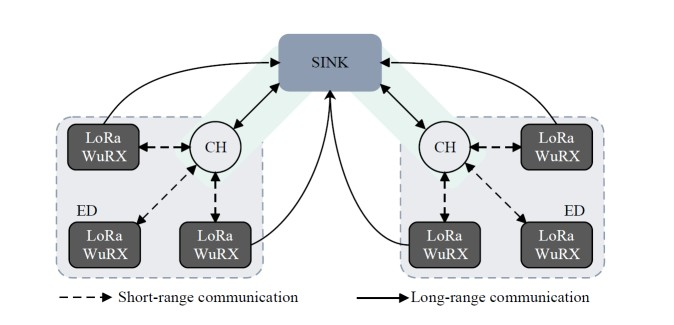

### Hardware Architecture
Hardware architecture of the heterogeneous communication mote used for testbed evaluation.

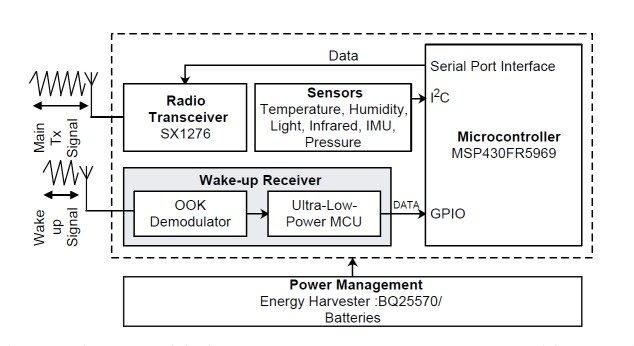

### Τesting Setup & Topology
The topology used in the experiments with different node designations.

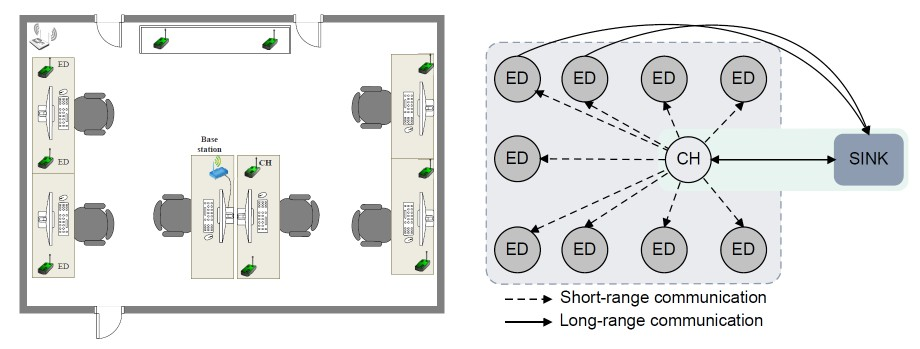

### Import Libraries

In [25]:
import math
import random
import numpy as np
import seaborn as sns
from scipy.stats import binom
import matplotlib.pyplot as plt

### Initializing Parameters


In [26]:
# time-on-air for every SET in milliseconds
ToApkt = [int(264), int(31), int(9)]
ToApkt = [int(264), int(124), int(62), int(31), int(18), int(9)]  # EXTENDED VERSION

# preamble for every SET in milliseconds
Preamble = [int(100), int(13), int(3)]

# 17ms (WuR) + 9,5ms (extra program or offset)
WuBArrivalTime = int(27)

# guard time
Gt = int(6)

# 20 km maximum range
MAX_Distance = 20000

MasterTable = []
NodesPerCycle = []

### Truncate Function for Reliability
Returns a value truncated to a specific number of decimal places.

In [27]:
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)
    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

### Find Time-on-air in ms for every Spreading Factor (SF) Function

In [28]:
def TimeOnAir(distance):
    d = int(distance)
    if d > 19997:
        d = 19997
    n_pre = 8
    BW = 500000 # 500 kHz
    SF = d // round(MAX_Distance / 6) + 7
    Rsym = pow(2, SF) / BW
    PL = 8
    if SF == 12:
        DE = 1
        CR = 2
    else:
        DE = 0
        CR = 1
    ToA = ((n_pre + 4.25) * Rsym) + ((8 + max(math.ceil((8 * PL - 4 * SF + 28 + 16 * CR) / (4 * (SF - 2 * DE))) * (CR + 4), 0)) * Rsym)
    ToA = round(ToA * 1000)
    return ToA

### End Device Class
The end device (ED) is <b>responsible for sensing</b> and equipped with both a <u>wake-up receiver</u> and a <u>LoRa transceiver</u>. The EDs are battery powered and, therefore, will spend most of the time in a <i>low-power mode, i.e., deep sleep state</i>.

In [29]:
class ED():

    def __init__(self, NodeID):
        self.ID = NodeID + 1
        self.ToA = 0
        
    def SetToA(self, time):
        self.ToA = time
        
    def GetNodeInfo(self):
        print("Node ID:", self.ID)

### Cluster Head Class
The cluster head (CH) is in charge of <b>managing the nodes in the cluster</b> and relaying <b>commands from the gateway to the EDs</b>. Depending on the application scenario and the energy availability, the CH can either operate in a duty cycle mode or can always be listening. The nodes designated as CHs are also equipped with <u>both radios</u>. Each CH is assigned a <i>unique ID address</i> allowing the sink to query each CH at a time, thus reducing the interference from other clusters.

In [30]:
class CH():

    def __init__(self, ClusterID):
        self.ID = ClusterID + 1
        self.NodesInCluster = []
        self.ToA = 0
        
    def SetToA(self, time):
        self.ToA = time

    def AddNode(self, NodeID):
        self.NodesInCluster.append(NodeID)

    def GetClusterInfo(self):
        print("Cluster ID:", self.ID)
        print("Nodes:", self.NodesInCluster)

### Sink (Gateway)
The sink acts as a <i>gateway</i> and is assumed to have <b>no energy constraints</b> and will be wall-powered. Therefore, the sink can be <u>always on</u> and <u>listening for any incoming data</u>. Unlike ED and CH, the sink <u>only offers long-range communication</u> without the wake-up radio interface.

### Packets Class

In [31]:
class Packet():

    def __init__(self, PacketID, NodeID, CreationTime):
        self.ID = PacketID + 1
        self.Node = NodeID + 1
        self.Time = CreationTime

    def GetPacketInfo(self):
        print("Packet ID:", self.ID)
        print("From Node:", self.Node)
        print("{ Creation Time:", self.Time, "}")

### Create Network

In [32]:
class Simulation():
    
    # initialization process, create nodes and assign them correctly to the cluster heads
    def __init__(self, TotalPackets, Intervals, NoNodes, NoClusters):
        self.TotalPackets = TotalPackets
        self.Cycle = Intervals * 1000
        self.Nodes = NoNodes
        self.Clusters = NoClusters
        self.EndNodes = [ED(i) for i in range(self.Nodes)]
        self.ClusterHeads = [CH(i) for i in range(self.Clusters)]
        for i in range(self.Nodes):
            x = i % self.Clusters
            self.ClusterHeads[x].AddNode(i + 1)

### Distributions

In [33]:
class Simulation(Simulation):

    # basic simulation function, create packets for every node
    def Sim(self, distribution, N):
        S = 0
        i = 0
        if distribution == "uniform":
            if N > self.Nodes:
                N = self.Nodes
        while S < self.TotalPackets:
            samples = -1
            if distribution == "normal":
                while samples < 0 or samples > self.Nodes:
                    samples = np.random.normal(loc=self.Nodes/2, scale=1.5, size=1)
                NodesPerCycle.append(int(round(samples[0])))
            elif distribution == "binomial":
                while samples < 0 or samples > self.Nodes:
                    samples = binom.rvs(n=self.Nodes+1, p=0.65, size=1)
                NodesPerCycle.append(int(round(samples[0])))
            elif distribution == "poisson":
                while samples < 0 or samples > self.Nodes:
                    samples = np.random.poisson(lam=self.Nodes/3, size=1)
                NodesPerCycle.append(int(round(samples[0])))
            else:
                NodesPerCycle.append(int(N))
            if NodesPerCycle[i] > self.Nodes or NodesPerCycle[i] < 0:
                NodesPerCycle[i] = random.randint(0, self.Nodes)
            S += NodesPerCycle[i]
            i += 1
        NodesPerCycle[i-1] -= S - self.TotalPackets
        c = 0
        PacketList = []
        for i in range(len(NodesPerCycle)):
            for t in range(NodesPerCycle[i]):
                PacketList.append(random.randint(c + 1, c + self.Cycle - 1))
            c += self.Cycle
        cycles = len(NodesPerCycle)
        packets = len(PacketList)
        if distribution == "normal":
            D = "Normal"
        elif distribution == "binomial":
            D = "Binomial"
        elif distribution == "poisson":
            D = "Poisson"
        else:
            D = "Uniform"
        print("~ Running Simulation using", D, "Distribution ~", "\n")
        print("Number of packets created:", packets, "\n")
        k = 0
        for i in range(cycles):
            nodes = [0] * self.Nodes
            j = 0
            t = random.randint(0, self.Nodes-1)
            while j < NodesPerCycle[i]:
                if nodes[t] == 0:
                    nodes[t] = 1
                    j += 1
                    message = Packet(k, t, PacketList[k])
                    MasterTable.append(message)
                    k += 1
                t = random.randint(0, self.Nodes-1)
            nodes.clear()

### On-Demand TDMA (TDMA)

In [34]:
class Simulation(Simulation):

    # basic On-Demand TDMA function
    def TDMA(self, Set, Type):
        print("~ TDMA Simulation starts -", Type, "mode ~", "\n")
        print("The Sink starts asking after a WARMUP PERIOD of", self.Cycle,
              "milliseconds in order for the end nodes to acquire their first packets", "\n")
        CycleList = []
        IndexList = []
        cycle_number = 1
        end_cycle = self.Cycle
        ToApkt_Set = ToApkt[Set - 1]
        packets = 0
        latency = 0
        while packets < self.TotalPackets:
            begin_cycle = end_cycle
            end_cycle += self.Cycle
            print("- The Sink asks for packets created in previous cycle (before the",
                  begin_cycle, "millisecond threshold), to be transmitted in current cycle (",
                  cycle_number, ") [", begin_cycle, "-", end_cycle, "]\n")
            n = 0
            start = begin_cycle - self.Cycle
            end = begin_cycle
            for i in range(self.TotalPackets):
                if start <= MasterTable[i].Time < end:
                    CycleList.append(MasterTable[i].Time)
                    IndexList.append(MasterTable[i].Node)
                    n += 1
                    packets += 1
                    if packets == self.TotalPackets:
                        break
            SortedList = [x for _,x in sorted(zip(IndexList, CycleList))]
            AllNodes = [0] * self.Nodes
            for k in range(len(IndexList)):
                AllNodes[IndexList[k]-1] = CycleList[k]
            for j in range(self.Nodes):
                found = False
                for i in range(self.TotalPackets):
                    if MasterTable[i].Time == AllNodes[j]:
                        found = True
                        print("Packet ID", MasterTable[i].ID, "created at", MasterTable[i].Time,
                            "milliseconds from Node", MasterTable[i].Node, "(Time-on-air =", ToApkt_Set, "ms)")
                if not(found):
                    print("Node", j+1, "has no packet on this cycle, NO communication with CH (Time-on-air =", ToApkt_Set, "ms)")
            if Type == "Broadcast":
                slot_time = WuBArrivalTime + ToApkt_Set * (self.Nodes + 1) + Gt * (self.Nodes - 1)
            else:
                slot_time = (2 * ToApkt_Set + WuBArrivalTime) * self.Nodes
            print("> Total delay in cycle:", slot_time, "milliseconds", "\n")
            cycle_number += 1
            latency += slot_time
            CycleList.clear()
            IndexList.clear()
        print("+ Total number of cycles performed:", cycle_number - 1)
        print("+ Mean data latency:", truncate(latency / (cycle_number - 1)))
        print("+ Reliability:", truncate(packets / self.TotalPackets, 2), "\n")

### Listen Before Talk (LBT)

In [35]:
class Simulation(Simulation):

    # basic Listen Before Talk function
    def LBT(self, Set):
        print("~ LBT Simulation starts ~", "\n")
        print("The Sink starts asking after a WARMUP PERIOD of", self.Cycle,
              "milliseconds in order for the end nodes to acquire their first packets", "\n")
        CycleList = []
        PacketIDList = []
        cycle_number = 1
        end_cycle = self.Cycle
        ToApkt_Set = ToApkt[Set - 1]
        Preamble_Set = Preamble[Set - 1]
        InitialBackoff = int(ToApkt_Set * Set * 2.104 * self.Nodes * self.Cycle / 10000)
        packets = 0
        latency = 0
        sent_packets = 0
        current_packets = 0        
        while packets < self.TotalPackets:
            begin_cycle = end_cycle
            end_cycle += self.Cycle
            print("- The Sink asks for packets created in previous cycle (before the",
                  begin_cycle, "millisecond threshold), to be transmitted in current cycle (",
                  cycle_number, ") [", begin_cycle, "-", end_cycle, "]\n")
            n = 0
            start = begin_cycle - self.Cycle
            end = begin_cycle
            slot_time = 0
            for i in range(self.TotalPackets):
                if start <= MasterTable[i].Time < end:
                    PacketIDList.append(i)
                    if self.Nodes == 1:
                        CycleList.append(self.Cycle * cycle_number)
                    else:
                        CycleList.append(random.randint(start + self.Cycle + 1, start + self.Cycle + InitialBackoff))
                    n += 1
                    packets += 1
                    if packets == self.TotalPackets:
                        break
            p = n                        
            flag = False
            collision = False
            while len(CycleList) != 0:
                OK = False
                if collision:
                    flag = True
                else:
                    flag = False
                minimum = min(CycleList)
                m = CycleList.index(minimum)
                pos = PacketIDList[m]
                done = True
                while done:
                    done = False
                    for i in range(n):
                        if minimum + Preamble_Set >= CycleList[i] and i != m:
                            CycleList[i] += random.randint(0, 2 * 1000)
                            done = True
                potential_collision = max(CycleList)   
                for i in range(n):
                    if CycleList[i] < potential_collision and i != m:
                        potential_collision = CycleList[i]
                if potential_collision != minimum:
                    if minimum + ToApkt_Set > potential_collision:
                        collision = True
                    else:
                        collision = False
                if flag:
                    if potential_collision == minimum:
                        collision = False
                else:                    
                    OK = True
                CycleList.remove(minimum)
                PacketIDList.remove(pos)
                n -= 1
                if OK:
                    sent_packets += 1
                    print("Packet ID", MasterTable[pos].ID, "created at", MasterTable[pos].Time,
                        "milliseconds from Node", MasterTable[pos].Node, "and sent at", minimum,
                        "milliseconds")
                    slot_time = minimum + 2 * ToApkt_Set + WuBArrivalTime - (start + self.Cycle)
            print("> Total delay in cycle:", slot_time, "milliseconds")
            print("~ Lost packets in this cycle:", p - (sent_packets - current_packets), "\n")
            current_packets = sent_packets
            latency += slot_time
            cycle_number += 1
            PacketIDList.clear()
        print("+ Total number of cycles performed:", cycle_number - 1)
        print("+ Mean data latency:", truncate(latency / (cycle_number - 1)))
        print("+ Reliability:", truncate(sent_packets / self.TotalPackets, 2))
        print("+ Total number of lost packets:", self.TotalPackets - sent_packets, "\n")

### Distance Dependent On-Demand TDMA (DD-TDMA)

In [36]:
class Simulation(Simulation):
        
    # Distance-Dependent On-Demand TDMA function
    def DD_TDMA(self):
        print("~ Distance Dependent TDMA Simulation starts ~", "\n")
        print("The Sink starts asking after a WARMUP PERIOD of", self.Cycle,
              "milliseconds in order for the end nodes to acquire their first packets", "\n")
        CycleList = []
        IndexList = []
        cycle_number = 1
        end_cycle = self.Cycle
        packets = 0
        latency = 0
        while packets < self.TotalPackets:
            begin_cycle = end_cycle
            end_cycle += self.Cycle
            print("- The Sink asks for packets created in previous cycle (before the",
                  begin_cycle, "millisecond threshold), to be transmitted in current cycle (",
                  cycle_number, ") [", begin_cycle, "-", end_cycle, "]\n")
            n = 0
            start = begin_cycle - self.Cycle
            end = begin_cycle
            for i in range(self.TotalPackets):
                if start <= MasterTable[i].Time < end:
                    CycleList.append(MasterTable[i].Time)
                    IndexList.append(MasterTable[i].Node)
                    n += 1
                    packets += 1
                    if packets == self.TotalPackets:
                        break
            SortedList = [x for _,x in sorted(zip(IndexList, CycleList))]
            AllNodes = [0] * self.Nodes
            for k in range(len(IndexList)):
                AllNodes[IndexList[k]-1] = CycleList[k]
            time = self.ClusterHeads[0].ToA
            slot_time = time + WuBArrivalTime
            print("Signal from Sink to Cluster Head (Time-on-air =", time, "ms)")
            for j in range(self.Nodes):
                found = False
                for i in range(self.TotalPackets):
                    if MasterTable[i].Time == AllNodes[j]:
                        found = True
                        time = self.EndNodes[MasterTable[i].Node-1].ToA
                        slot_time += time + Gt
                        print("Packet ID", MasterTable[i].ID, "created at", MasterTable[i].Time,
                              "milliseconds from Node", MasterTable[i].Node, "(Time-on-air =", time, "ms)")
                        if j+1 == self.Nodes:
                            slot_time -= Gt
                if not(found):
                    time = self.EndNodes[j].ToA
                    if time > (WuBArrivalTime + 9):
                        print("Node", j+1, "has no packet on this cycle, communicates with CH", "(Delay =", WuBArrivalTime + 9, "ms)")
                        slot_time += 9
                        if j+1 != self.Nodes:
                            slot_time += WuBArrivalTime
                    else:
                        print("Node", j+1, "has no packet on this cycle, NO communication with CH (Time-Slot Duration =", time, "ms)")
                        slot_time += time + Gt
                        if j+1 == self.Nodes:
                            slot_time -= Gt
            print("> Total delay in cycle:", slot_time, "milliseconds", "\n")
            cycle_number += 1
            latency += slot_time
            CycleList.clear()
            IndexList.clear()
            AllNodes.clear()
        print("+ Total number of cycles performed:", cycle_number - 1)
        print("+ Mean data latency:", truncate(latency / (cycle_number - 1)))
        print("+ Reliability:", truncate(packets / self.TotalPackets, 2), "\n")        

In [37]:
class Simulation(Simulation):

# update node distances function
    def FindToA(self, code):
        
        List = [13000, 12500, 12000, 11000, 10500, 9000, 8000, 7500, 7000]
        S_CH = 10000
        
        #List = [20000, 19500, 19000, 18000, 17300, 16000, 15000, 14500, 14000]
        #S_CH = 17000
        
        print("~ Setting Distances in the Network ~", "\n")
        for i in range(self.Clusters):
            if code != 0:
                val = input("Distance Sink -> CH" + str(i+1) + ": ")
                val = TimeOnAir(val)
                self.ClusterHeads[i].SetToA(val)
            else:  
                print("Distance Sink -> CH" + str(i+1) + ":", S_CH)
                val = TimeOnAir(S_CH)
                self.ClusterHeads[i].SetToA(val)
        print("---------------------------")
        for i in range(self.Nodes):
            if code != 0:
                val = input("Distance ED" + str(i+1) + " -> Sink: ")
                val = TimeOnAir(val)
                self.EndNodes[i].SetToA(val)
            else:
                print("Distance ED" + str(i+1) + " -> Sink:", List[i])
                val = TimeOnAir(List[i])
                self.EndNodes[i].SetToA(val)
        print("\n")

In [38]:
class Simulation(Simulation):

# print network architecture information function
    def PrintAll(self):
        print("---------------")
        print("End Devices:", len(self.EndNodes), "\n---------------")
        print("Cluster Heads:", len(self.ClusterHeads), "\n---------------")
        for i in range(self.Clusters):
            self.ClusterHeads[i].GetClusterInfo()
            print("---------------")
        print("\n")

### Set Network Parameters

In [39]:
run = Simulation(500, 10, 9, 1)
run.PrintAll()
run.FindToA(0)
run.Sim("normal", 9)
Set = 3

---------------
End Devices: 9 
---------------
Cluster Heads: 1 
---------------
Cluster ID: 1
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
---------------


~ Setting Distances in the Network ~ 

Distance Sink -> CH1: 10000
---------------------------
Distance ED1 -> Sink: 13000
Distance ED2 -> Sink: 12500
Distance ED3 -> Sink: 12000
Distance ED4 -> Sink: 11000
Distance ED5 -> Sink: 10500
Distance ED6 -> Sink: 9000
Distance ED7 -> Sink: 8000
Distance ED8 -> Sink: 7500
Distance ED9 -> Sink: 7000


~ Running Simulation using Normal Distribution ~ 

Number of packets created: 500 



### Listen Before Talk Execution

In [40]:
run.LBT(Set)

~ LBT Simulation starts ~ 

The Sink starts asking after a WARMUP PERIOD of 10000 milliseconds in order for the end nodes to acquire their first packets 

- The Sink asks for packets created in previous cycle (before the 10000 millisecond threshold), to be transmitted in current cycle ( 1 ) [ 10000 - 20000 ]

Packet ID 2 created at 7648 milliseconds from Node 1 and sent at 10154 milliseconds
Packet ID 3 created at 1072 milliseconds from Node 7 and sent at 10538 milliseconds
Packet ID 1 created at 976 milliseconds from Node 4 and sent at 10767 milliseconds
Packet ID 4 created at 283 milliseconds from Node 6 and sent at 12150 milliseconds
Packet ID 5 created at 163 milliseconds from Node 9 and sent at 13277 milliseconds
> Total delay in cycle: 3428 milliseconds
~ Lost packets in this cycle: 0 

- The Sink asks for packets created in previous cycle (before the 20000 millisecond threshold), to be transmitted in current cycle ( 2 ) [ 20000 - 30000 ]

Packet ID 7 created at 11524 millisecond

### On-Demand TDMA Execution (Unicast Mode)

In [41]:
run.TDMA(Set, "Unicast")

~ TDMA Simulation starts - Unicast mode ~ 

The Sink starts asking after a WARMUP PERIOD of 10000 milliseconds in order for the end nodes to acquire their first packets 

- The Sink asks for packets created in previous cycle (before the 10000 millisecond threshold), to be transmitted in current cycle ( 1 ) [ 10000 - 20000 ]

Packet ID 2 created at 7648 milliseconds from Node 1 (Time-on-air = 62 ms)
Node 2 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Node 3 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 1 created at 976 milliseconds from Node 4 (Time-on-air = 62 ms)
Node 5 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 4 created at 283 milliseconds from Node 6 (Time-on-air = 62 ms)
Packet ID 3 created at 1072 milliseconds from Node 7 (Time-on-air = 62 ms)
Node 8 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 5 created at 163 milliseconds fro

### On-Demand TDMA Execution (Broadcast Mode)

In [42]:
run.TDMA(Set, "Broadcast")

~ TDMA Simulation starts - Broadcast mode ~ 

The Sink starts asking after a WARMUP PERIOD of 10000 milliseconds in order for the end nodes to acquire their first packets 

- The Sink asks for packets created in previous cycle (before the 10000 millisecond threshold), to be transmitted in current cycle ( 1 ) [ 10000 - 20000 ]

Packet ID 2 created at 7648 milliseconds from Node 1 (Time-on-air = 62 ms)
Node 2 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Node 3 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 1 created at 976 milliseconds from Node 4 (Time-on-air = 62 ms)
Node 5 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 4 created at 283 milliseconds from Node 6 (Time-on-air = 62 ms)
Packet ID 3 created at 1072 milliseconds from Node 7 (Time-on-air = 62 ms)
Node 8 has no packet on this cycle, NO communication with CH (Time-on-air = 62 ms)
Packet ID 5 created at 163 milliseconds f

### Distance Dependent On-Demand TDMA Execution

In [43]:
run.DD_TDMA()

~ Distance Dependent TDMA Simulation starts ~ 

The Sink starts asking after a WARMUP PERIOD of 10000 milliseconds in order for the end nodes to acquire their first packets 

- The Sink asks for packets created in previous cycle (before the 10000 millisecond threshold), to be transmitted in current cycle ( 1 ) [ 10000 - 20000 ]

Signal from Sink to Cluster Head (Time-on-air = 62 ms)
Packet ID 2 created at 7648 milliseconds from Node 1 (Time-on-air = 62 ms)
Node 2 has no packet on this cycle, communicates with CH (Delay = 36 ms)
Node 3 has no packet on this cycle, communicates with CH (Delay = 36 ms)
Packet ID 1 created at 976 milliseconds from Node 4 (Time-on-air = 62 ms)
Node 5 has no packet on this cycle, communicates with CH (Delay = 36 ms)
Packet ID 4 created at 283 milliseconds from Node 6 (Time-on-air = 31 ms)
Packet ID 3 created at 1072 milliseconds from Node 7 (Time-on-air = 31 ms)
Node 8 has no packet on this cycle, NO communication with CH (Time-Slot Duration = 31 ms)
Packet 

### Distribution Plot

In [44]:
# set number of nodes for distribution plots
nodes = 9

### Normal Distribution

[5, 20, 71, 161, 242, 234, 164, 77, 25, 1]


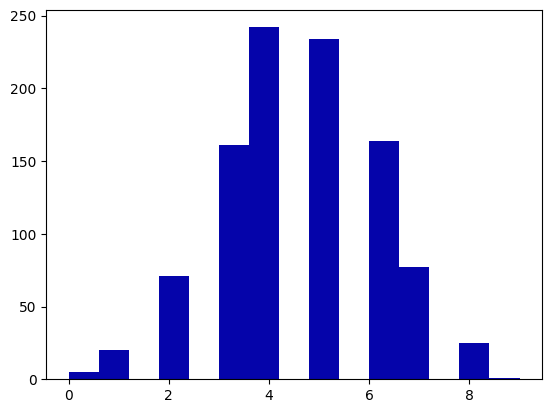

In [45]:
# probability = 4.5/9
data1 = np.random.normal(loc=nodes/2, scale=1.5, size=1000)
energy1 = [0] * (nodes+1)
for i in range(len(data1)):
    data1[i] = round(data1[i])
    if data1[i] < 0:
        data1[i] = 0
    elif data1[i] > nodes:
        data1[i] = nodes
    energy1[int(data1[i])] += 1
print(energy1)
plt.hist(x=data1, bins='auto', color='#0504aa')
plt.show()

### Binomial Distribution

[0, 1, 8, 23, 60, 144, 247, 264, 176, 77]


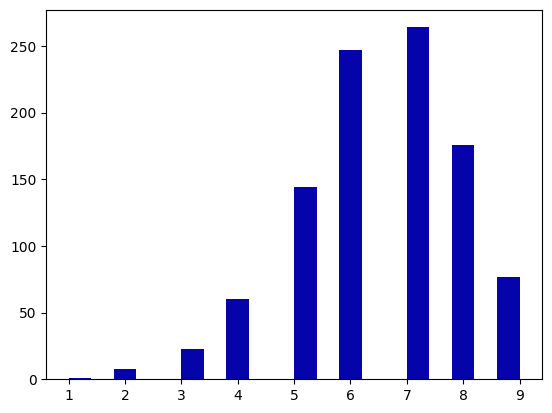

In [46]:
# probability = 6.5/9
data2 = binom.rvs(n=nodes+1, p=0.65, size=1000)
energy2 = [0] * (nodes+1)
for i in range(len(data2)):
    data2[i] = round(data2[i])
    if data2[i] < 0:
        data2[i] = 0
    elif data2[i] > nodes:
        data2[i] = nodes
    energy2[int(data2[i])] += 1
print(energy2)
plt.hist(x=data2, bins='auto', color='#0504aa')
plt.show()

### Poisson Distribution

[53, 155, 198, 239, 170, 101, 44, 26, 10, 4]


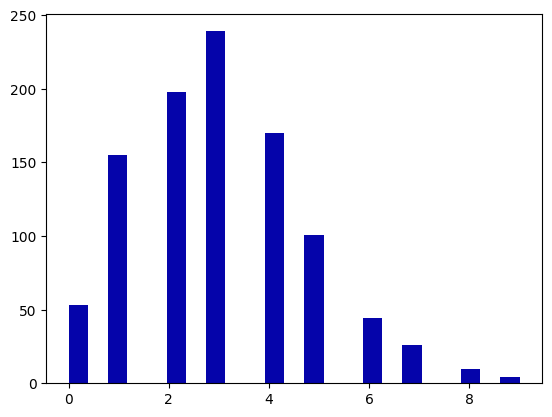

In [47]:
# probability = 3/9
data3 = np.random.poisson(lam=nodes/3, size=1000)
energy3 = [0] * (nodes+1)
for i in range(len(data3)):
    data3[i] = round(data3[i])
    if data3[i] < 0:
        data3[i] = 0
    elif data3[i] > nodes:
        data3[i] = nodes
    energy3[int(data3[i])] += 1
print(energy3)
plt.hist(x=data3, bins='auto', color='#0504aa')
plt.show()